In [1]:
!pip install sklearn-crfsuite
!pip install seqeval

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 21.7 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 KB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16179 sha256=6247b80bfcb633835bd2249606aa148d6c2996e073f7e5fc06a532798ab746ed
  Stored in directory: /root/.cache/pip/wheels/ad/5c/ba/05fa33fa5855777b7d686e843ec07452f22a66a138e290e732
Successfully built seqeval


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import os
from sklearn.metrics import f1_score
from seqeval.metrics import precision_score, recall_score, f1_score, classification_report

https://www.kaggle.com/code/naseralqaydeh/named-entity-recognition-ner-with-tensorflow


https://www.kaggle.com/competitions/coleridgeinitiative-show-us-the-data/discussion/228376

In [3]:
!pip list --format=freeze > requirements.txt

In [3]:
df = pd.read_csv("/content/drive/MyDrive/ATC_DATA/BIO-Annotations-1.csv")
#df = df.fillna(method='ffill')
df.head(10)

,sentence,Words,Tag
0,1,us,B-callsign
1,1,air,I-callsign
2,1,two,I-callsign
3,1,thirty,I-callsign
4,1,seven,o
5,1,washington,I-frequency1
6,1,departure,B-frequency1
7,1,radar,I-frequency1
8,1,contact,I-frequency1
9,1,climb,B-level1


In [4]:
df.isnull().sum()

sentence    0
Words       0
Tag         0
dtype: int64

In [5]:
words = list(set(df['Words'].values))
num_words = len(words)
tags = list(set(df['Tag'].values))#iob2 tags 
num_tags = len(tags)
num_words, num_tags

(1173, 17)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114047 entries, 0 to 114046
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   sentence  114047 non-null  int64 
 1   Words     114047 non-null  object
 2   Tag       114047 non-null  object
dtypes: int64(1), object(2)
memory usage: 2.6+ MB


In [7]:
# Retrive sentences and tags from the dataset
class SentenceGetter(object):
        
        def __init__(self, data):
            self.n_sent = 1
            self.data = data
            self.empty = False
            agg_func = lambda s: [(w, t) for w, t in zip(s["Words"].values.tolist(),
                                                            s["Tag"].values.tolist())]
            self.grouped = self.data.groupby("sentence").apply(agg_func)
            self.sentences = [s for s in self.grouped]

        def get_next(self):
            try:
                s = self.grouped["Sentence: {}".format(self.n_sent)]
                self.n_sent += 1
                return s
            except:
                return None

getter = SentenceGetter(df)
sentences = getter.sentences

In [8]:
getter

In [9]:
sentences

[[('us', 'B-callsign'),
  ('air', 'I-callsign'),
  ('two', 'I-callsign'),
  ('thirty', 'I-callsign'),
  ('seven', 'o'),
  ('washington', 'I-frequency1'),
  ('departure', 'B-frequency1'),
  ('radar', 'I-frequency1'),
  ('contact', 'I-frequency1'),
  ('climb', 'B-level1'),
  ('and', 'I-level1'),
  ('maintain', 'I-level1'),
  ('one', 'o'),
  ('five', 'I-callsign'),
  ('thousand', 'o')],
 [('delta', 'B-callsign'),
  ('two', 'I-callsign'),
  ('oh', 'o'),
  ('nine', 'I-callsign'),
  ('turn', 'B-heading1'),
  ('left', 'I-heading1'),
  ('heading', 'B-heading1'),
  ('two', 'I-callsign'),
  ('four', 'I-callsign'),
  ('zero', 'I-callsign')],
 [('us', 'B-callsign'),
  ('air', 'I-callsign'),
  ('two', 'I-callsign'),
  ('thirty', 'I-callsign'),
  ('seven', 'o'),
  ('turn', 'B-heading1'),
  ('left', 'I-heading1'),
  ('heading', 'B-heading1'),
  ('two', 'I-callsign'),
  ('one', 'o'),
  ('zero', 'I-callsign'),
  ('join', 'B-direct1'),
  ('the', 'o'),
  ('gordonsville', 'o'),
  ('zero', 'I-callsign'),
 

In [10]:
word2idx = {w: i for i, w in enumerate(words)}
print (word2idx)
tag2idx = {t: i for i, t in enumerate(tags)}
print(tag2idx)

{'brazil': 0, 'holding': 1, 'ramp': 2, 'frequency': 3, 'eagle': 4, 'expected': 5, 'si-': 6, 'slightly': 7, 'just': 8, 'washing': 9, 'course': 10, 'wanted': 11, "tower's": 12, 'enter': 13, 'without': 14, 'going': 15, 'approach': 16, 'pass': 17, 'shorten': 18, 'been': 19, 'draper': 20, 'few': 21, 'called': 22, 'aerostar': 23, 'arrow': 24, 'swissair': 25, "pattern's": 26, 'lets': 27, 'sixty-four': 28, 'national': 29, 'affirmative': 30, "they'll": 31, 'star': 32, 'usa1127': 33, 'code': 34, 'maam': 35, 'approved': 36, 'apologize': 37, 'day': 38, 'prior': 39, 'yank': 40, 'best': 41, 'triple': 42, 'midex': 43, 'assured': 44, 'aircraft': 45, 'overhead': 46, 'good': 47, 'atlantic': 48, 'gonna': 49, 'back': 50, 'skylane': 51, 'allentown': 52, 'remain': 53, 'visibility': 54, 'thornton': 55, 'appreciate': 56, 'alkid': 57, 'archer': 58, 'departure': 59, 'sorry': 60, 'clouds': 61, 'had': 62, 'ardmore': 63, 'planed': 64, 'tail': 65, 'inbound': 66, 'nottingham': 67, 'marina': 68, 'group': 69, 'cat': 7

In [11]:
tag2idx.keys()

dict_keys(['o', 'I-speed1', 'I-direct1', 'B-level1', 'B-frequency1', 'B-speed1', 'B-level2', 'I-level1', 'B-direct1', 'B-callsign', 'I-heading1', 'B-traffic1', 'B-heading1', 'I-traffic1', 'I-frequency1', 'I-callsign', 'I-traffic2'])

In [12]:
idx2word = {i: w for w, i in word2idx.items()}
idx2tag = {i: w for w, i in tag2idx.items()}

In [13]:
idx2tag

{0: 'o',
 1: 'I-speed1',
 2: 'I-direct1',
 3: 'B-level1',
 4: 'B-frequency1',
 5: 'B-speed1',
 6: 'B-level2',
 7: 'I-level1',
 8: 'B-direct1',
 9: 'B-callsign',
 10: 'I-heading1',
 11: 'B-traffic1',
 12: 'B-heading1',
 13: 'I-traffic1',
 14: 'I-frequency1',
 15: 'I-callsign',
 16: 'I-traffic2'}

In [14]:
from keras_preprocessing.sequence import pad_sequences#add numbers to the sequences to make them all be the same length. 
from keras.utils import to_categorical

In [15]:
max_len = 50

X = [[word2idx[w[0]] for w in s] for s in sentences]
X = pad_sequences(maxlen = max_len, sequences = X, padding='post', value=num_words-1)

y = [[tag2idx[w[1]] for w in s] for s in sentences]
y = pad_sequences(maxlen = max_len, sequences = y, padding = 'post', value = tag2idx['o'])
y = [to_categorical(i, num_classes=num_tags) for i in y]

In [16]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [17]:
x_train

array([[ 368,  130,  180, ..., 1172, 1172, 1172],
       [ 101,  922,  547, ..., 1172, 1172, 1172],
       [ 426, 1107,  112, ..., 1172, 1172, 1172],
       ...,
       [ 752,  610,  112, ..., 1172, 1172, 1172],
       [ 673,  474,  547, ..., 1172, 1172, 1172],
       [1143,  639,  440, ..., 1172, 1172, 1172]], dtype=int32)

In [18]:
print("Size of training input data : ", x_train.shape)
print("Size of training output data : ", np.array(y_train).shape)
print("Size of testing input data : ", x_test.shape)
print("Size of testing output data : ", np.array(y_test).shape)

Size of training input data :  (5769, 50)
Size of training output data :  (5769, 50, 17)
Size of testing input data :  (2473, 50)
Size of testing output data :  (2473, 50, 17)


In [19]:
# Let's check the first sentence before and after processing.
print('*****Before Processing first sentence : *****\n', ' '.join([w[0] for w in sentences[0]]))
print('*****After Processing first sentence : *****\n ', X[0])

*****Before Processing first sentence : *****
 us air two thirty seven washington departure radar contact climb and maintain one five thousand
*****After Processing first sentence : *****
  [ 426 1107  474  112  442 1044   59  472  786  404  223  834  922  444
  840 1172 1172 1172 1172 1172 1172 1172 1172 1172 1172 1172 1172 1172
 1172 1172 1172 1172 1172 1172 1172 1172 1172 1172 1172 1172 1172 1172
 1172 1172 1172 1172 1172 1172 1172 1172]


In [21]:
# First label before and after processing.
print('*****Before Processing first sentence : *****\n', ' '.join([w[1] for w in sentences[0]]))
print('*****After Processing first sentence : *****\n ', y[0])

*****Before Processing first sentence : *****
 B-callsign I-callsign I-callsign I-callsign o I-frequency1 B-frequency1 I-frequency1 I-frequency1 B-level1 I-level1 I-level1 o I-callsign o
*****After Processing first sentence : *****
  [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0.

In [22]:
from keras import Model, Input
from keras.layers import LSTM, Embedding, Dense,GRU
from keras.layers import TimeDistributed, SpatialDropout1D, Bidirectional

In [23]:
input_word = Input(shape=(max_len, ))
model = Embedding(input_dim = num_words, output_dim = max_len, input_length = max_len)(input_word)
model = SpatialDropout1D(0.2)(model)
model = Bidirectional(GRU(units=100, return_sequences=True, recurrent_dropout=0.2))(model)
out = TimeDistributed(Dense(num_tags, activation='softmax'))(model)
model = Model(input_word, out)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50)]              0         
                                                                 
 embedding (Embedding)       (None, 50, 50)            58650     
                                                                 
 spatial_dropout1d (SpatialD  (None, 50, 50)           0         
 ropout1D)                                                       
                                                                 
 bidirectional (Bidirectiona  (None, 50, 200)          91200     
 l)                                                              
                                                                 
 time_distributed (TimeDistr  (None, 50, 17)           3417      
 ibuted)                                                         
                                                             

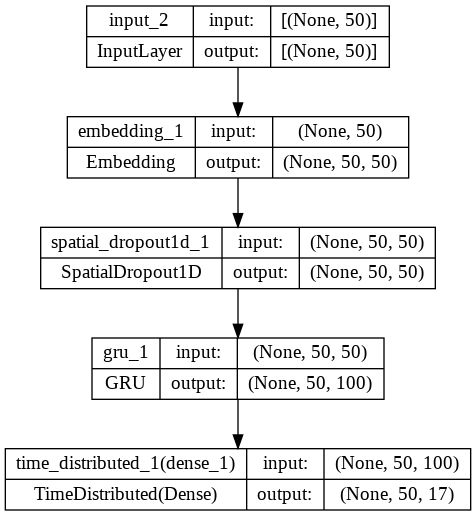

In [48]:
from keras.utils import plot_model
plot_model(model,'Bi-GRU.png',show_shapes= True)

In [49]:
import tensorflow as tf

In [50]:
model.compile(tf.keras.optimizers.Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])


In [51]:
import numpy as np
history = model.fit(
    x_train, np.array(y_train),
    validation_split=0.2,
    batch_size = 32,
    epochs = 25
    
)

Epoch 1/25
145/145 [==============================] - 11s 59ms/step - loss: 1.9771 - accuracy: 0.8166 - val_loss: 0.6798 - val_accuracy: 0.8471
Epoch 2/25
145/145 [==============================] - 8s 58ms/step - loss: 0.6295 - accuracy: 0.8480 - val_loss: 0.6004 - val_accuracy: 0.8471
Epoch 3/25
145/145 [==============================] - 8s 56ms/step - loss: 0.5687 - accuracy: 0.8480 - val_loss: 0.5482 - val_accuracy: 0.8471
Epoch 4/25
145/145 [==============================] - 8s 57ms/step - loss: 0.5225 - accuracy: 0.8483 - val_loss: 0.5005 - val_accuracy: 0.8482
Epoch 5/25
145/145 [==============================] - 8s 57ms/step - loss: 0.4775 - accuracy: 0.8517 - val_loss: 0.4551 - val_accuracy: 0.8570
Epoch 6/25
145/145 [==============================] - 8s 57ms/step - loss: 0.4315 - accuracy: 0.8770 - val_loss: 0.4050 - val_accuracy: 0.8929
Epoch 7/25
145/145 [==============================] - 8s 57ms/step - loss: 0.3786 - accuracy: 0.9062 - val_loss: 0.3475 - val_accuracy: 0.916

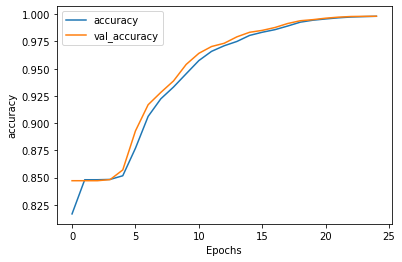

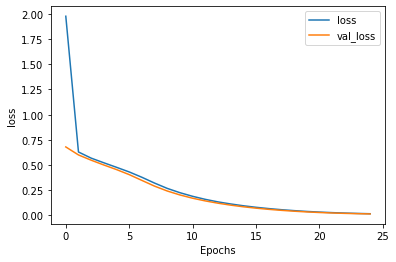

In [52]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss");

In [53]:
result=model.predict(x_test,np.array(y_test).any())

2473/2473 [==============================] - 24s 10ms/step


In [54]:
# Evaluation
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=-1)
y_test_true = np.argmax(y_test, -1)

78/78 [==============================] - 1s 10ms/step


In [55]:
# Convert the index to tag
y_pred = [[idx2tag[i] for i in row] for row in y_pred]
y_test_true = [[idx2tag[i] for i in row] for row in y_test_true] 

In [56]:
print("F1-score is : {:.1%}".format(f1_score(y_test_true, y_pred)))

F1-score is : 98.6%


In [57]:
y_pred=y_pred
y_true=y_test_true
report = classification_report(y_pred, y_true)
print(report)

              precision    recall  f1-score   support

           _       0.99      0.99      0.99      6571
    callsign       0.99      0.99      0.99      6734
     direct1       0.00      0.00      0.00         0
  frequency1       0.99      1.00      0.99      1446
    heading1       1.00      1.00      1.00      2001
      level1       0.99      0.94      0.97      1424
      level2       0.00      0.00      0.00         0
      speed1       0.95      0.82      0.88       431
    traffic1       0.00      0.00      0.00         0
    traffic2       0.00      0.00      0.00         0

   micro avg       0.98      0.99      0.99     18607
   macro avg       0.59      0.57      0.58     18607
weighted avg       0.99      0.99      0.99     18607



In [58]:
model.save('/content/drive/MyDrive/ATC_DATA/model_Bi-GRU.h5')

In [59]:
model1=tf.keras.models.load_model("/content/drive/MyDrive/ATC_DATA/model_Bi-GRU.h5")

In [60]:
test_loss,test_accuracy=model1.evaluate(x_test,np.array(y_test))
print('Test Loss:'+ str(test_loss))
print('Test Accuracy:'+ str(test_accuracy))

78/78 [==============================] - 1s 10ms/step - loss: 0.0149 - accuracy: 0.9982
Test Loss:0.014882087707519531
Test Accuracy:0.998196542263031


In [61]:
i = np.random.randint(0, x_test.shape[0])
p = model.predict(np.array([x_test[i]]))
p = np.argmax(p, axis=-1)

y_true = np.argmax(np.array(y_test), axis=-1)[i]

print('{:15}{:15}\t {}\n'.format('Word', 'True', 'Pred'))
print('-'*30)
for w, true, pred in zip(x_test[i], y_true, p[0]):
    print('{:15}{}\t{}'.format(words[w-1], idx2tag[true], idx2tag[pred]))

1/1 [==============================] - 0s 19ms/step
Word           True           	 Pred

------------------------------
factor         B-callsign	B-callsign
pad            I-callsign	I-callsign
seventy-nine   I-callsign	I-callsign
they           I-callsign	I-callsign
you'll         I-heading1	I-heading1
seventy-five   B-heading1	B-heading1
turn           I-callsign	I-callsign
leveling       o	o
boxer          I-callsign	I-callsign
dulles         o	o
dulles         o	o
dulles         o	o
dulles         o	o
dulles         o	o
dulles         o	o
dulles         o	o
dulles         o	o
dulles         o	o
dulles         o	o
dulles         o	o
dulles         o	o
dulles         o	o
dulles         o	o
dulles         o	o
dulles         o	o
dulles         o	o
dulles         o	o
dulles         o	o
dulles         o	o
dulles         o	o
dulles         o	o
dulles         o	o
dulles         o	o
dulles         o	o
dulles         o	o
dulles         o	o
dulles         o	o
dulles         o	o
dulles       

In [62]:
import re
def make_prediction(sentence):
    #sentence = re.sub('[^a-zA-Z0-9]',' ', sentence)
    tokens = sentence.split(" ")
    #print(tokens)
    max_len = 50
    num_words = len(tokens)
    X_pred = [[word2idx[w] for w in tokens]]
    #print(X_pred)
    X_pred = pad_sequences(maxlen=max_len, sequences=X_pred, padding="post", value=num_words-1)
    p = model.predict(np.array([X_pred[0]]))
    p = np.argmax(p, axis=-1)
    print("{:15}\t{}\n".format("Word", "Pred"))
    print("-"*30)
    tags_pred = []
    token_list =[]
    
    for (w, pred) in zip(X_pred[0][:len(tokens)], p[0][:len(tokens)]):
        print("{:15}\t{}".format(words[w-1], idx2tag[pred]))
        tags_pred.append(idx2tag[pred])
        tags_pred.append('o')
        token_list.append(words[w-1])
        token_list.append(' ')
        
    output_tuple = list(zip(token_list[:-1], tags_pred[:-1]))
    #print(output_tuple)
    return output_tuple


In [63]:
X_pred = make_prediction("us air two thirty seven climb and maintain flight level two one zero")
X_pred

1/1 [==============================] - 0s 19ms/step
Word           	Pred

------------------------------
its            	B-callsign
waco           	I-callsign
turn           	I-callsign
hotel          	I-callsign
leveling       	o
davison        	B-level1
moment         	I-level1
indicates      	I-level1
thirteen       	I-level1
henson         	B-level1
turn           	I-callsign
shorter        	o
boxer          	I-callsign


[('its', 'B-callsign'),
 (' ', 'o'),
 ('waco', 'I-callsign'),
 (' ', 'o'),
 ('turn', 'I-callsign'),
 (' ', 'o'),
 ('hotel', 'I-callsign'),
 (' ', 'o'),
 ('leveling', 'o'),
 (' ', 'o'),
 ('davison', 'B-level1'),
 (' ', 'o'),
 ('moment', 'I-level1'),
 (' ', 'o'),
 ('indicates', 'I-level1'),
 (' ', 'o'),
 ('thirteen', 'I-level1'),
 (' ', 'o'),
 ('henson', 'B-level1'),
 (' ', 'o'),
 ('turn', 'I-callsign'),
 (' ', 'o'),
 ('shorter', 'o'),
 (' ', 'o'),
 ('boxer', 'I-callsign')]

In [64]:
#import pickle

In [65]:
"""model.save('/content/drive/My Drive/ner_BIGRU.h5')

with open('/content/drive/My Drive/NERobjs-BIGRU.pkl', 'wb') as f: 
    pickle.dump([word2idx, words, tags], f)"""

"model.save('/content/drive/My Drive/ner_BIGRU.h5')\n\nwith open('/content/drive/My Drive/NERobjs-BIGRU.pkl', 'wb') as f: \n    pickle.dump([word2idx, words, tags], f)"

In [66]:
"""from keras.models import load_model
model = load_model("/content/drive/My Drive/ner_lstm.h5")

with open('/content/drive/My Drive/NERobjs.pkl','rb') as f:  
    word2idx, words, tags = pickle.load(f)"""

'from keras.models import load_model\nmodel = load_model("/content/drive/My Drive/ner_lstm.h5")\n\nwith open(\'/content/drive/My Drive/NERobjs.pkl\',\'rb\') as f:  \n    word2idx, words, tags = pickle.load(f)'

GRU

In [67]:
input_word = Input(shape=(max_len, ))
model = Embedding(input_dim = num_words, output_dim = max_len, input_length = max_len)(input_word)
model = SpatialDropout1D(0.2)(model)
model = GRU(units=100, return_sequences=True, recurrent_dropout=0.2)(model)
out = TimeDistributed(Dense(num_tags, activation='softmax'))(model)
model = Model(input_word, out)
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 50)]              0         
                                                                 
 embedding_2 (Embedding)     (None, 50, 50)            58650     
                                                                 
 spatial_dropout1d_2 (Spatia  (None, 50, 50)           0         
 lDropout1D)                                                     
                                                                 
 gru_2 (GRU)                 (None, 50, 100)           45600     
                                                                 
 time_distributed_2 (TimeDis  (None, 50, 17)           1717      
 tributed)                                                       
                                                                 
Total params: 105,967
Trainable params: 105,967
Non-trainab

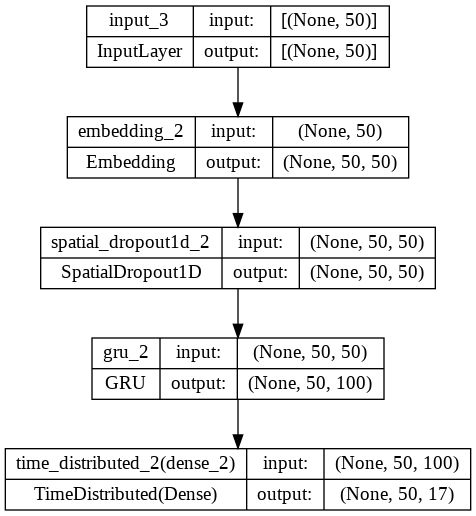

In [68]:
plot_model(model,'GRU.png',show_shapes= True)

In [69]:
model.compile(tf.keras.optimizers.Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
import numpy as np
history = model.fit(
    x_train, np.array(y_train),
    validation_split=0.2,
    batch_size = 32,
    epochs = 25
    
)

Epoch 1/25
145/145 [==============================] - 11s 60ms/step - loss: 2.1080 - accuracy: 0.7651 - val_loss: 0.6969 - val_accuracy: 0.8471
Epoch 2/25
145/145 [==============================] - 8s 57ms/step - loss: 0.6462 - accuracy: 0.8480 - val_loss: 0.6155 - val_accuracy: 0.8471
Epoch 3/25
145/145 [==============================] - 8s 57ms/step - loss: 0.5817 - accuracy: 0.8480 - val_loss: 0.5612 - val_accuracy: 0.8471
Epoch 4/25
145/145 [==============================] - 8s 58ms/step - loss: 0.5381 - accuracy: 0.8481 - val_loss: 0.5200 - val_accuracy: 0.8475
Epoch 5/25
145/145 [==============================] - 9s 59ms/step - loss: 0.4969 - accuracy: 0.8495 - val_loss: 0.4769 - val_accuracy: 0.8507
Epoch 6/25
145/145 [==============================] - 8s 58ms/step - loss: 0.4532 - accuracy: 0.8662 - val_loss: 0.4286 - val_accuracy: 0.8833
Epoch 7/25
145/145 [==============================] - 8s 58ms/step - loss: 0.4026 - accuracy: 0.8986 - val_loss: 0.3735 - val_accuracy: 0.911

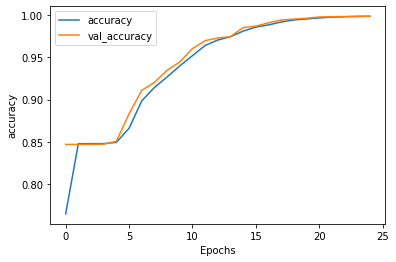

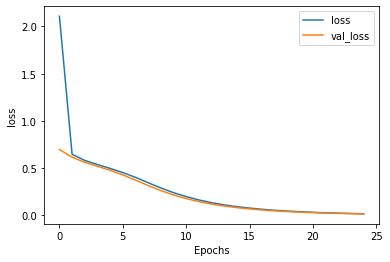

In [70]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss");

In [71]:
model.evaluate(x_test, np.array(y_test))

78/78 [==============================] - 1s 11ms/step - loss: 0.0154 - accuracy: 0.9984


[0.015357446856796741, 0.9984148740768433]

In [72]:
# Evaluation
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=-1)
y_test_true = np.argmax(y_test, -1)

78/78 [==============================] - 1s 10ms/step


In [73]:
# Convert the index to tag
y_pred = [[idx2tag[i] for i in row] for row in y_pred]
y_test_true = [[idx2tag[i] for i in row] for row in y_test_true] 

In [74]:
print("F1-score is : {:.1%}".format(f1_score(y_test_true, y_pred)))

F1-score is : 98.8%


In [75]:
y_pred=y_pred
y_true=y_test_true
report = classification_report(y_pred, y_true)
print(report)

              precision    recall  f1-score   support

           _       0.99      0.99      0.99      6572
    callsign       1.00      1.00      1.00      6741
     direct1       0.00      0.00      0.00         0
  frequency1       0.99      0.98      0.98      1474
    heading1       1.00      1.00      1.00      2005
      level1       0.99      0.95      0.97      1415
      level2       0.00      0.00      0.00         0
      speed1       0.97      0.89      0.93       407
    traffic1       0.00      0.00      0.00         0
    traffic2       0.00      0.00      0.00         0

   micro avg       0.99      0.99      0.99     18614
   macro avg       0.60      0.58      0.59     18614
weighted avg       1.00      0.99      0.99     18614



In [76]:
i = np.random.randint(0, x_test.shape[0])
p = model.predict(np.array([x_test[i]]))
p = np.argmax(p, axis=-1)

y_true = np.argmax(np.array(y_test), axis=-1)[i]

print('{:15}{:15}\t {}\n'.format('Word', 'True', 'Pred'))
print('-'*30)
for w, true, pred in zip(x_test[i], y_true, p[0]):
    print('{:15}{}\t{}'.format(words[w-1], idx2tag[true], idx2tag[pred]))

1/1 [==============================] - 0s 17ms/step
Word           True           	 Pred

------------------------------
waco           I-callsign	I-callsign
looks          o	o
pad            I-callsign	I-callsign
pad            I-callsign	I-callsign
boxer          I-callsign	I-callsign
plan           o	o
g              I-callsign	I-callsign
thought        I-traffic2	B-level1
direct         o	o
going          o	o
immediately    o	o
going          o	o
that           o	o
pad            I-callsign	I-callsign
something      o	o
correction     o	o
any            o	o
twenty-two     B-level1	B-level1
penn           o	o
advise         o	o
containment    o	o
seventy        o	o
bryar          o	o
turn           I-callsign	I-callsign
leveling       o	o
below          I-frequency1	I-frequency1
indicates      I-level1	I-level1
turn           I-callsign	I-callsign
shorter        o	o
boxer          I-callsign	I-callsign
closed         I-speed1	I-speed1
dulles         o	o
dulles         o	o
dulles    